# Variant functional consequences

This notebook provides a summary of the functional consequences of lead variants


## Data Loading

The data required for the analysis is loaded from the `computed maf` dataset.


In [ ]:
from __future__ import annotations

import pandas as pd
import patchworklib as pw
import plotnine as pn
from gentropy.common.session import Session
from pyspark.sql import Column, Window
from pyspark.sql import functions as f

from manuscript_methods import OpenTargetsTheme, calculate_protein_altering_proportion
from manuscript_methods.datasets import LeadVariantEffect


In [2]:
session = Session(extended_spark_conf={"spark.driver.memory": "40G"})
lead_maf_dataset_path = "../../data/lead_variant_effect_filtered"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/03 10:10:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/07/03 10:10:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/07/03 10:10:50 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
session.spark


In [6]:
# Limit to only cis-pQTL, GWAS and eQTL studies
dataset = LeadVariantEffect.from_parquet(session, lead_maf_dataset_path)


In [ ]:
maf_vep_dataset = dataset.df.select(
    "variantId",
    "leadVariantConsequence.*",
    "studyStatistics.studyType",
    "majorLdPopulationMaf.value",
    "rescaledStatistics.*",
).select(
    "variantId",
    "mostSevereConsequence.type",
    "mostSevereConsequence.transcriptConsequence.consequenceScore",
    "studyType",
    "value",
    "estimatedBeta",
)


## Proportion of altering / non altering vs maf bins


In [14]:
PRECISION = 20  # Needs to be the power of 10
PRECISION_FACTOR = len(str(PRECISION))  # Number of digits in the precision factor
upper_limit = f.ceil(f.col("value") * PRECISION) / PRECISION
lower_limit = f.floor(f.col("value") * PRECISION) / PRECISION
bucket_dataset = (
    maf_vep_dataset.withColumns(
        {
            "minRange": f.round(
                f.when(upper_limit == lower_limit, lower_limit - 1 / PRECISION).otherwise(lower_limit), PRECISION_FACTOR
            ),
            "maxRange": upper_limit,
        }
    )
    .withColumn("midPoint", f.round((f.col("minRange") + f.col("maxRange")) / 2, PRECISION_FACTOR + 1))
    .withColumn("bucket", f.concat(f.col("minRange"), f.lit("-"), f.col("maxRange")))
    .withColumn("vepProportion", calculate_protein_altering_proportion(f.col("consequenceScore")))
    .withColumn(
        "meanAbsEstimatedBeta", f.mean(f.abs(f.col("estimatedBeta"))).over(Window.partitionBy("bucket", "studyType"))
    )
    .withColumn(
        "stddevAbsEstimatedBeta",
        f.stddev(f.abs(f.col("estimatedBeta"))).over(Window.partitionBy("bucket", "studyType")),
    )
    .orderBy("bucket")
    .select(
        "variantId",
        "type",
        "vepProportion.*",
        "consequenceScore",
        "studyType",
        "bucket",
        f.col("value").alias("MAF"),
        "minRange",
        "maxRange",
        "midPoint",
        "stddevAbsEstimatedBeta",
        "meanAbsEstimatedBeta",
    )
)


In [15]:
data = bucket_dataset.drop_duplicates(["bucket", "studyType"]).toPandas()


25/07/03 10:14:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[0.025, 0.075, 0.125, 0.175, 0.225, 0.275, 0.325, 0.375, 0.425, 0.475]


/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/scales/scale_manual.py:45: PlotnineWarning:

The palette of scale_fill_manual can return a maximum of 3 values. 4 were requested from it.

/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/scales/scale_manual.py:45: PlotnineWarning:

The palette of scale_color_manual can return a maximum of 3 values. 4 were requested from it.



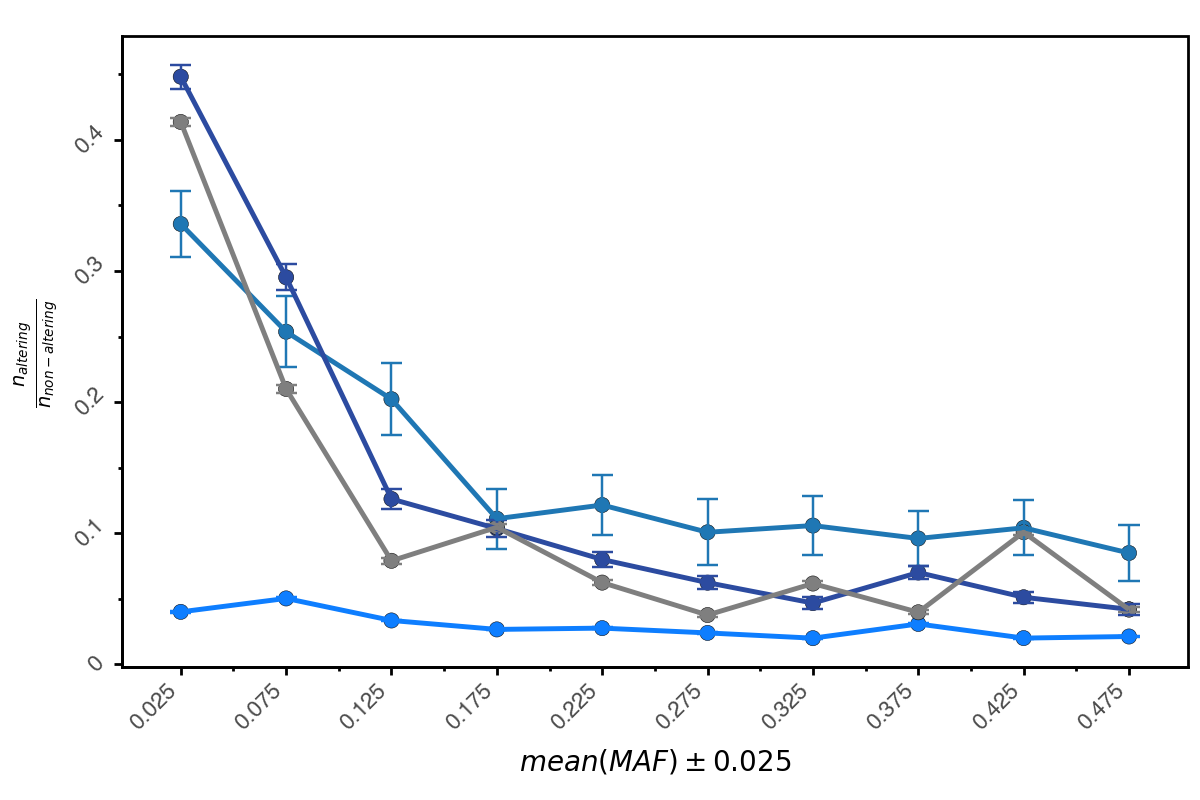

<Figure Size: (600 x 400)>

In [16]:
study_type_totals = data.groupby("studyType")["totalInBucket"].sum()
totals_map = {cat: f"{cat} (N={study_type_totals[cat]:.2e})" for cat in study_type_totals.index}
data["totals"] = data["studyType"].map(totals_map)
labels = data.drop_duplicates(subset=["studyType", "totals"])
REM = 10
breaks = [x for x in data["midPoint"].unique()]
print(breaks)
plot = (
    pn.ggplot(
        data,
        pn.aes(x="midPoint", y="alteringNonAlteringProportionInBucket", fill="studyType"),
    )
    # + pn.geom_col(position="dodge")
    + pn.geom_point(pn.aes(fill="studyType"), stroke=0.1, size=3)
    + pn.geom_errorbar(
        pn.aes(
            ymin="alteringNonAlteringProportionInBucket - stdErr",
            ymax="alteringNonAlteringProportionInBucket + stdErr",
            x="midPoint",
            color="studyType",
        ),
        width=0.01,
        # position=pn.position_dodge(width=0.9),
    )
    + pn.labs(
        # title="Proportion of lead variant effects in replicated credible sets",
        x=r"$mean(MAF)\pm{0.025}$",
        y=r"$\frac{n_{altering}}{n_{non-altering}}$ ",
    )
    + OpenTargetsTheme.theme
    # Remove the legend
    + pn.theme(legend_position="none")
    # + pn.facet_wrap(nrow=3, facets="studyType", scales="free_y")
    + pn.geom_line(
        pn.aes(x="midPoint", y="alteringNonAlteringProportionInBucket", group="studyType", color="studyType"),
        size=1,
    )
    + pn.theme(figure_size=(6, 4))
    + pn.scale_fill_manual(
        values=["#1f77b4", "#0e7eff", "#2c4ba0"],
        name="Study Type",
        labels=totals_map,
    )
    + pn.scale_color_manual(
        values=["#1f77b4", "#0e7eff", "#2c4ba0"],
        name="Study Type",
        labels=totals_map,
    )
    + pn.scale_x_continuous(
        breaks=[x for x in data["midPoint"].unique()],
        labels=[x for x in data["midPoint"].unique()],
    )
)
plot


## Mean absolute estimated effect size vs MAF bins


[0.025, 0.075, 0.125, 0.175, 0.225, 0.275, 0.325, 0.375, 0.425, 0.475]


/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/scales/scale_manual.py:45: PlotnineWarning:

The palette of scale_fill_manual can return a maximum of 3 values. 4 were requested from it.

/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/scales/scale_manual.py:45: PlotnineWarning:

The palette of scale_color_manual can return a maximum of 3 values. 4 were requested from it.



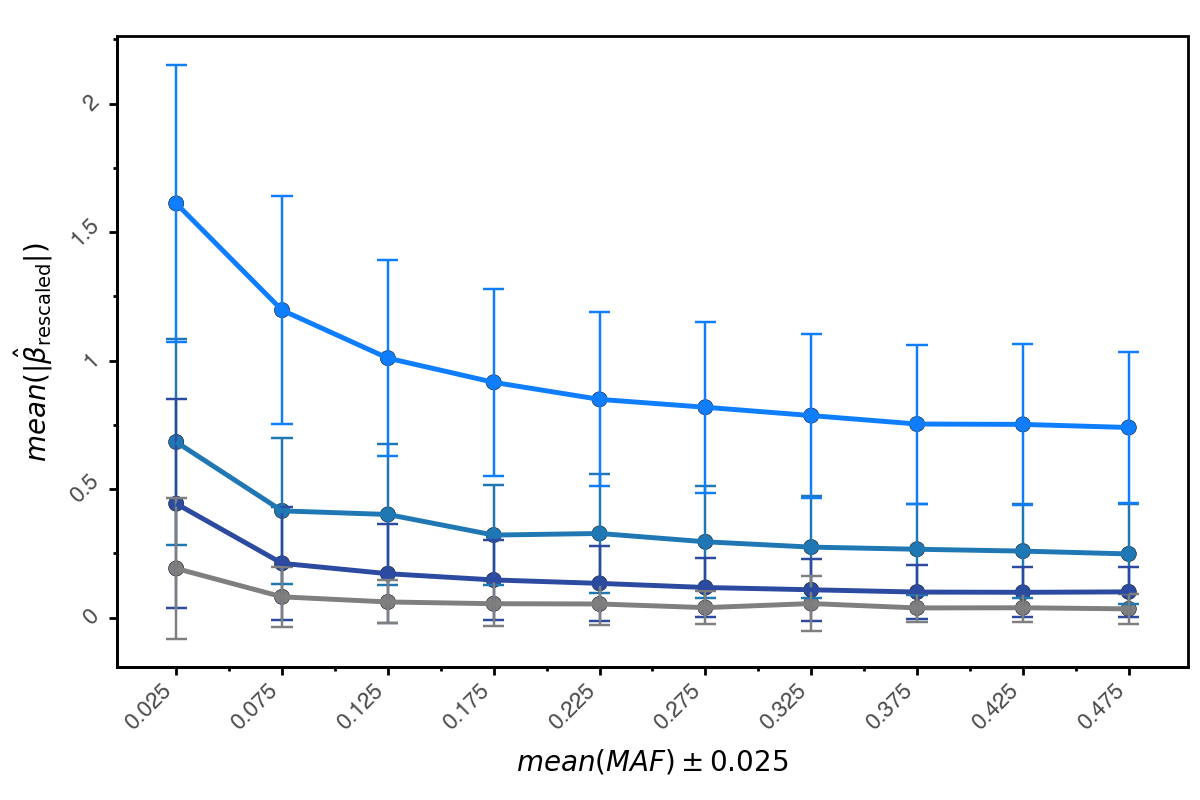

<Figure Size: (600 x 400)>

In [17]:
study_type_totals = data.groupby("studyType")["totalInBucket"].sum()
totals_map = {cat: f"{cat} (N={study_type_totals[cat]:.2e})" for cat in study_type_totals.index}
data["totals"] = data["studyType"].map(totals_map)
labels = data.drop_duplicates(subset=["studyType", "totals"])
REM = 10
breaks = [x for x in data["midPoint"].unique()]
print(breaks)
plot2 = (
    pn.ggplot(
        data,
        pn.aes(x="midPoint", y="meanAbsEstimatedBeta", fill="studyType"),
    )
    # + pn.geom_col(position="dodge")
    + pn.geom_point(pn.aes(fill="studyType"), stroke=0.1, size=3)
    + pn.geom_errorbar(
        pn.aes(
            ymin="meanAbsEstimatedBeta - stddevAbsEstimatedBeta",
            ymax="meanAbsEstimatedBeta + stddevAbsEstimatedBeta",
            x="midPoint",
            color="studyType",
        ),
        width=0.01,
        # position=pn.position_dodge(width=0.9),
    )
    + pn.labs(
        # title="Proportion of lead variant effects in replicated credible sets",
        x=r"$mean(MAF)\pm{0.025}$",
        y=r"$mean(|\hat{\beta}_{\mathrm{rescaled}}|)$",
    )
    + OpenTargetsTheme.theme
    # Remove the legend
    + pn.theme(legend_position="none")
    # + pn.facet_wrap(nrow=3, facets="studyType", scales="free_y")
    + pn.geom_line(
        pn.aes(x="midPoint", y="meanAbsEstimatedBeta", group="studyType", color="studyType"),
        size=1,
    )
    + pn.theme(figure_size=(6, 4))
    + pn.scale_fill_manual(
        values=["#1f77b4", "#0e7eff", "#2c4ba0"],
        name="Study Type",
        labels=totals_map,
    )
    + pn.scale_color_manual(
        values=["#1f77b4", "#0e7eff", "#2c4ba0"],
        name="Study Type",
        labels=totals_map,
    )
    + pn.scale_x_continuous(
        breaks=[x for x in data["midPoint"].unique()],
        labels=[x for x in data["midPoint"].unique()],
    )
)
plot2


## Proportion of altering / non altering vs abs(estimatedBeta) bins


In [18]:
PRECISION = 2  # Needs to be the power of 10
PRECISION_FACTOR = len(str(PRECISION)) - 1  # Number of digits in the precision factor
upper_limit = f.ceil(f.col("absEstimatedBeta") * PRECISION) / PRECISION
lower_limit = f.floor(f.col("absEstimatedBeta") * PRECISION) / PRECISION

bucket_dataset = (
    maf_vep_dataset.withColumn("absEstimatedBeta", f.abs("estimatedBeta"))
    .withColumns(
        {
            "minRange": f.when(upper_limit == lower_limit, lower_limit - 1 / PRECISION).otherwise(lower_limit),
            "maxRange": upper_limit,
        }
    )
    .withColumn("midPoint", f.round((f.col("minRange") + f.col("maxRange")) / 2, PRECISION_FACTOR + 2))
    .withColumn("bucket", f.concat(f.col("minRange"), f.lit("-"), f.col("maxRange")))
    .withColumn("vepProportion", calculate_protein_altering_proportion(f.col("consequenceScore")))
    .orderBy("bucket")
    .select(
        "variantId",
        "type",
        "vepProportion.*",
        "consequenceScore",
        "studyType",
        "bucket",
        "absEstimatedBeta",
        "minRange",
        "maxRange",
        "midPoint",
    )
)


In [20]:
data = bucket_dataset.drop_duplicates(["bucket", "studyType"]).toPandas()


/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/scales/scale_manual.py:45: PlotnineWarning:

The palette of scale_fill_manual can return a maximum of 3 values. 4 were requested from it.

/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/scales/scale_manual.py:45: PlotnineWarning:

The palette of scale_color_manual can return a maximum of 3 values. 4 were requested from it.

/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning:

geom_errorbar : Removed 2 rows containing missing values.

/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/scales/scale_manual.py:45: PlotnineWarning:

The palette of scale_fill_manual can return a maximum of 3 values. 4 were requested from it.

/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/scales/scale_manual.py:45: PlotnineWarning:

The palette of scale_

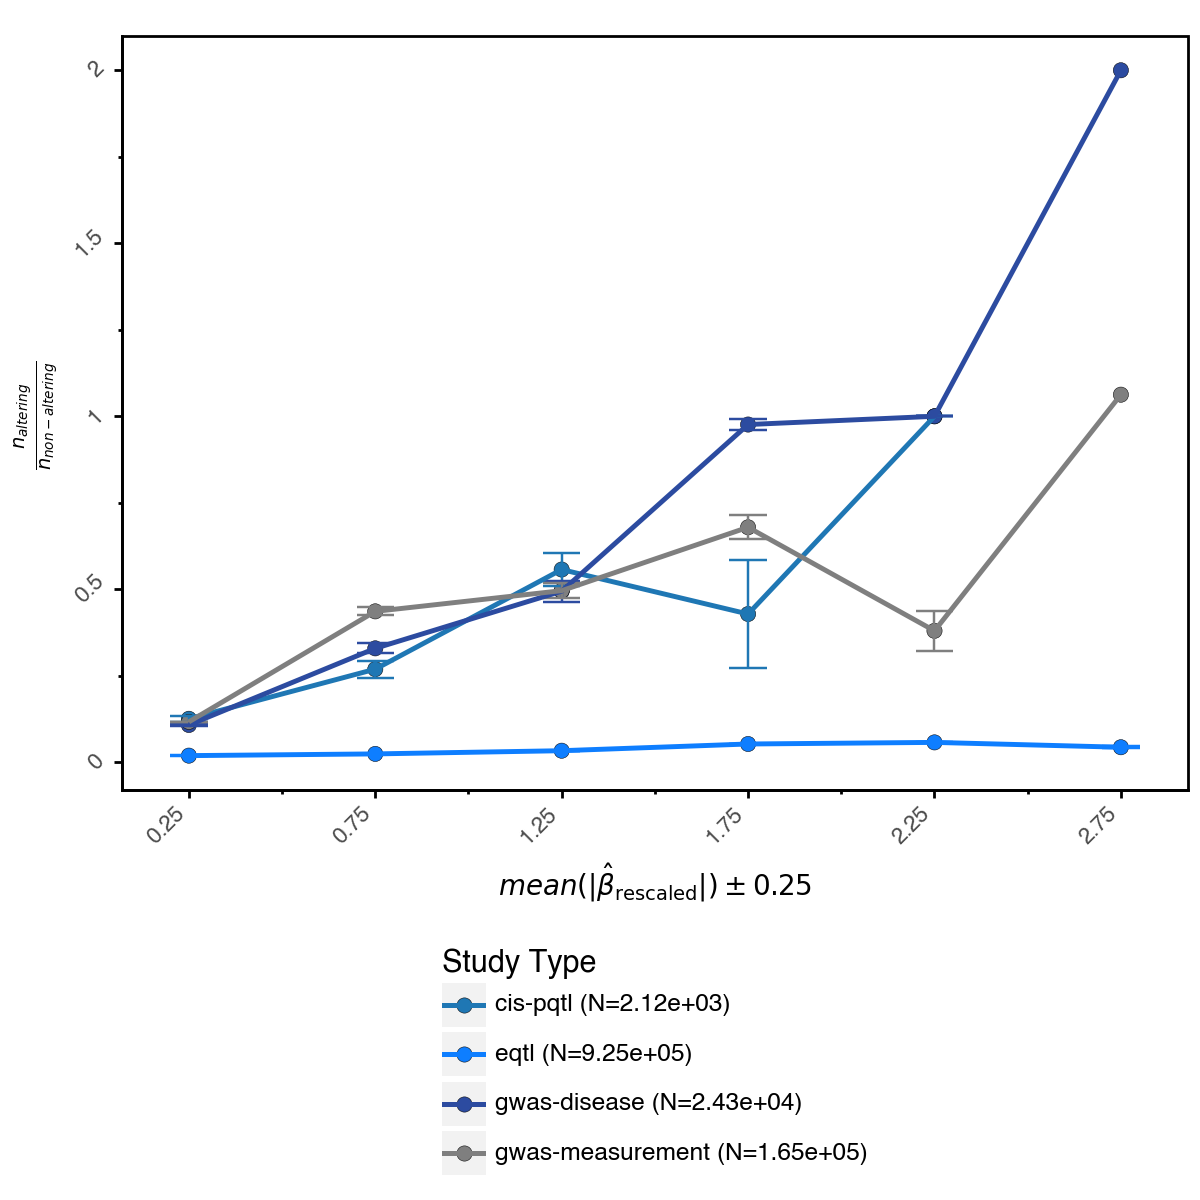

<Figure Size: (600 x 600)>

In [21]:
study_type_totals = data.groupby("studyType")["totalInBucket"].sum()
totals_map = {cat: f"{cat} (N={study_type_totals[cat]:.2e})" for cat in study_type_totals.index}
data["totals"] = data["studyType"].map(totals_map)
labels = data.drop_duplicates(subset=["studyType", "totals"])
REM = 10

plot3 = (
    pn.ggplot(
        data,
        pn.aes(
            x="midPoint",
            y="alteringNonAlteringProportionInBucket",
            fill="studyType",
        ),
    )
    + pn.geom_point(pn.aes(fill="studyType"), stroke=0.1, size=3)
    + pn.geom_errorbar(
        pn.aes(
            ymin="alteringNonAlteringProportionInBucket - stdErr",
            ymax="alteringNonAlteringProportionInBucket + stdErr",
            x="midPoint",
            color="studyType",
        ),
        width=0.1,
    )
    + pn.labs(
        # title="Proportion of Protein-Altering Variants by Rescaled Effect Size Bucket",
        x=r"$mean(|\hat{\beta}_{\mathrm{rescaled}}|)\pm{0.25}$",
        y=r"$\frac{n_{altering}}{n_{non-altering}}$ ",
    )
    + pn.scale_x_continuous(
        breaks=[x for x in data["midPoint"].unique()],
        labels=[x for x in data["midPoint"].unique()],
    )
    + OpenTargetsTheme.theme
    # Remove the legend
    # + pn.theme(legend_position="none")
    # + pn.facet_wrap(nrow=3, facets="studyType", scales="free_y")
    + pn.geom_line(
        pn.aes(x="midPoint", y="alteringNonAlteringProportionInBucket", group="studyType", color="studyType"),
        size=1,
    )
    + pn.scale_fill_manual(
        values=["#1f77b4", "#0e7eff", "#2c4ba0"],
        name="Study Type",
        labels=totals_map,
    )
    + pn.scale_color_manual(
        values=["#1f77b4", "#0e7eff", "#2c4ba0"],
        name="Study Type",
        labels=totals_map,
    )
    + pn.theme(figure_size=(6, 6))
    + pn.theme(legend_position="bottom", legend_direction="vertical")
)
plot3


## Save plots into 1 figure


In [23]:
plots = {"vep_proportion_vs_maf": plot, "effect_size_vs_maf": plot2, "vep_proportion_vs_abs_beta": plot3}
g1 = pw.load_ggplot(plot)
g2 = pw.load_ggplot(plot2)
g3 = pw.load_ggplot(plot3)


In [24]:
# Combine plots with shared legend
s = g1 / g2 | g3  # g3 has the legend at the bottom


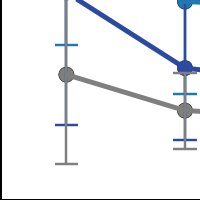

In [25]:
s.savefig("plots/variant_functional_consequence.jpg", dpi=300, bbox_inches="tight", facecolor="white", edgecolor="none")
